As a behavioural customer segmentation,it stands for Recency, Frequency and Monetary Value.
Recency:How recently each customer purchase
Frequncy:Measure how many purchases have been made in the last 12 month
Monetary Value: how much customers have spents in the last 12 months 
    
RFM values can be grouped in sveral ways:
   1. Break customers into equal size based on percentile values of each metric (e.g, quantiles )
   2. assign high /low value value based on Pareto 80/20 Cut
   3. Cutomer_based on business knowledge
  
    
 

Process of calculating percentiles:
    1. Sort customers based on that metric
    2. Break customers into pre_defined number of groups of equal size
    3. Assign a label to each group
    Assigning labels
Highest score to the best metric - best is not always highest e.g. recency.
In this case, the label is inverse - the more recent the customer, the better.
##The assigment was prepared by Karolis Urbonis at Datamap

In [1]:
import pandas as pd
online=pd.read_csv("Ch1-data/online.csv")
online
#to delete the unnamed colour, couldnt do through index_col=0
online=online.loc[:, ~online.columns.str.contains('^Unnamed')]

In [2]:
online['TotalSum']=online['Quantity']*online['UnitPrice']
online.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalSum'],
      dtype='object')

We are starting with a preprocesses online DtaFrame with only the latest 12 month of data.

In [3]:
print('Min:{};Max:{}'.format(min(online.InvoiceDate),max(online.InvoiceDate)))

Min:2010-12-01 08:26:00;Max:2011-12-09 12:49:00


Let's create a hypothetical snapshot_day data as if we're doing analysis recently.
class datetime.timedelta: A duration expressing the difference between two date, time, or datetime instances to microsecond resolution




In [4]:
#this is the only correct way to create a hypothetical snapshot_day data as if we are doing snalysis recently
import datetime
from datetime import timedelta
date_1 = datetime.datetime.strptime(max(online.InvoiceDate), '%Y-%m-%d %H:%M:%S')

day_add=datetime.timedelta(days=1)

snapshot_date=date_1+day_add#the last day + one day after
print(snapshot_date,date_1,day_add)
#tried snapshot_date = date_1 + datetime.timedelta(days=1)#the last day + one day after but didn't work

2011-12-10 12:49:00 2011-12-09 12:49:00 1 day, 0:00:00


In [5]:

snapshot_date = datetime.date(snapshot_date.year, snapshot_date.month, snapshot_date.day)#to get rid of time
print(snapshot_date)



2011-12-10


In [6]:

online['InvoiceDate']=pd.to_datetime(online['InvoiceDate'],format='%Y-%m-%d %H:%M:%S')
# Define a function that will parse the date
def get_day(x): return datetime.datetime(x.year, x.month,x.day) 


In [7]:
# Create InvoiceDay column
online['InvoiceDay'] = online['InvoiceDate'].apply(get_day)


In [8]:
# Group by CustomerID and select the InvoiceDay value
grouping = online.groupby('CustomerID')['InvoiceDay'] 


In [9]:
# Assign a max InvoiceDay value to the dataset to find the dfifference with the recent transaction
online['Cohortmax'] = grouping.transform('max')
print(online['InvoiceDate'],online['Cohortmax'])

0       2011-10-25 08:26:00
1       2011-11-20 11:56:00
2       2011-07-14 13:35:00
3       2011-11-23 15:53:00
4       2011-05-25 13:36:00
5       2011-03-20 12:06:00
6       2011-11-20 12:13:00
7       2011-11-08 15:37:00
8       2011-03-21 15:10:00
9       2011-05-13 14:58:00
10      2011-05-09 12:42:00
11      2011-11-04 11:41:00
12      2011-05-22 11:41:00
13      2011-06-12 12:03:00
14      2011-09-22 16:37:00
15      2011-09-20 12:53:00
16      2011-10-26 13:07:00
17      2011-08-22 14:37:00
18      2011-07-19 12:39:00
19      2011-09-01 16:18:00
20      2011-06-19 15:36:00
21      2011-03-10 10:53:00
22      2011-08-14 10:38:00
23      2011-02-20 15:51:00
24      2011-10-17 14:01:00
25      2010-12-02 12:11:00
26      2011-08-08 13:53:00
27      2010-12-07 13:29:00
28      2011-11-30 14:17:00
29      2011-01-06 15:14:00
                ...        
70834   2011-01-14 14:02:00
70835   2011-07-29 10:00:00
70836   2011-04-14 17:58:00
70837   2011-04-21 16:37:00
70838   2011-07-13 1

In [10]:
snapshot_year=snapshot_date.year
snapshot_month=snapshot_date.month
snapshot_day=snapshot_date.day



In [11]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day
# Get the integers for date parts from the `Invoiceday` column
invoice_year, invoice_month, invoice_day = get_date_int(online, 'Cohortmax') 
# Get the integers for date parts from the `Cohortmax` column

In [12]:
# Calculate difference in years
years_diff = snapshot_year-invoice_year 

# Calculate difference in months
months_diff = snapshot_month-invoice_month

# Calculate difference in days
days_diff = snapshot_day- invoice_day

# Extract the difference in days from all previous values-measurement of dates can eb different
online['Invoicediff'] = years_diff * 365 + months_diff * 30 + days_diff 

In [13]:
# Aggregate data on a customer level
datamart = online.groupby(['CustomerID']).agg({
'Invoicediff':'max',   #lambda x: int((snapshot_date - x.max()).days) was not applicable
'InvoiceNo': 'count',
'TotalSum': 'sum'})


# Rename columns for easier interpretation
datamart.rename(columns = {
'Invoicediff':'Recency',
'InvoiceNo': 'Frequency',
'TotalSum': 'MonetaryValue'}, inplace=True)
# Check the first rows
datamart.head(5)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,3,27,992.82
12748,1,967,7522.06
12749,4,37,813.45
12820,4,17,268.02
12822,70,9,146.15


In [14]:
online.sort_values(by='CustomerID')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum,InvoiceDay,Cohortmax,Invoicediff
13161,577104,23522,WALL ART DOG AND BALL,6,2011-11-17 17:13:00,2.89,12747,United Kingdom,17.34,2011-11-17,2011-12-07,3
50015,541677,82482,WOODEN PICTURE FRAME WHITE FINISH,12,2011-01-20 14:01:00,2.55,12747,United Kingdom,30.60,2011-01-20,2011-12-07,3
47007,558265,82484,WOOD BLACK BOARD ANT WHITE FINISH,24,2011-06-28 10:06:00,6.75,12747,United Kingdom,162.00,2011-06-28,2011-12-07,3
60979,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747,United Kingdom,30.60,2010-12-05,2011-12-07,3
67084,581163,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2011-12-07 14:34:00,2.08,12747,United Kingdom,20.80,2011-12-07,2011-12-07,3
10642,554549,22606,WOODEN SKITTLES GARDEN SET,1,2011-05-25 09:57:00,15.95,12747,United Kingdom,15.95,2011-05-25,2011-12-07,3
51501,563949,21754,HOME BUILDING BLOCK WORD,6,2011-08-22 10:38:00,5.95,12747,United Kingdom,35.70,2011-08-22,2011-12-07,3
3694,581163,82484,WOOD BLACK BOARD ANT WHITE FINISH,36,2011-12-07 14:34:00,6.75,12747,United Kingdom,243.00,2011-12-07,2011-12-07,3
41327,581163,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2011-12-07 14:34:00,2.95,12747,United Kingdom,17.70,2011-12-07,2011-12-07,3
36562,577104,22120,WELCOME WOODEN BLOCK LETTERS,3,2011-11-17 17:13:00,9.95,12747,United Kingdom,29.85,2011-11-17,2011-12-07,3


In [15]:
#datamart.CustomerID.sort_values()
datamart.sort_values(by='CustomerID')

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,3,27,992.82
12748,1,967,7522.06
12749,4,37,813.45
12820,4,17,268.02
12822,70,9,146.15
12823,294,1,306.00
12824,59,6,106.38
12826,3,17,291.26
12827,33,2,44.55


We have successfully built a dataset with recency, frequency, and monetary values!

Put customers in to different segments. 
We need to assign quartile to each segment
Recent customers should be called active .


In [16]:
datamart_rfm=datamart.copy() #need it for k_means


In [17]:
# Create labels for Recency
r_labels=range(3,0,-1) #the smaller the number of recency the better a
# Create labels for Frequency
f_labels=range(1,4) #the higher the number of transaction the better
m_labels=range(1,4)#the higher the number of monetary value, the better

In [18]:
r_groups=pd.qcut(datamart['Recency'],3,labels=r_labels)
f_groups=pd.qcut(datamart['Frequency'],3,labels=f_labels)
m_groups=pd.qcut(datamart['MonetaryValue'],3,labels=m_labels)

In [19]:
datamart=datamart.assign(R=r_groups.values,F=f_groups.values,M=m_groups.values)


In [20]:
# Calculate RFM_Score
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
print(datamart['RFM_Score'].head())

CustomerID
12747    9.0
12748    9.0
12749    9.0
12820    9.0
12822    6.0
Name: RFM_Score, dtype: float64


In [21]:
#TO FIND THE MONETARY VALUE FOR RFM-SCORE=9
datamart.groupby('RFM_Score').agg({
'Recency': 'mean',
'Frequency': 'mean',
'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3.0         231.2       2.5          36.3   526
4.0         137.6       4.1          65.3   528
5.0         116.2       6.7         151.0   597
6.0          68.2      10.7         178.9   521
7.0          51.6      16.0         303.6   495
8.0          33.0      29.6         558.8   468
9.0          10.8      63.7        1342.1   566

In [22]:
#to create a custom segmentation based on RFM_Score values
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Top'
    elif ((df['RFM_Score'] >=5) and (df['RFM_Score'] < 9)):
        return 'Middle'
    else:
        return 'Low'

In [23]:
# Create a new variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)


In [24]:
# Print the header with top 5 rows to the console
print(datamart.head(10))

            Recency  Frequency  MonetaryValue  R  F  M  RFM_Score RFM_Level
CustomerID                                                                 
12747             3         27         992.82  3  3  3        9.0       Top
12748             1        967        7522.06  3  3  3        9.0       Top
12749             4         37         813.45  3  3  3        9.0       Top
12820             4         17         268.02  3  3  3        9.0       Top
12822            70          9         146.15  2  2  2        6.0    Middle
12823           294          1         306.00  1  1  3        5.0    Middle
12824            59          6         106.38  2  2  2        6.0    Middle
12826             3         17         291.26  3  3  3        9.0       Top
12827            33          2          44.55  2  1  1        4.0       Low
12828             8         12         195.40  3  2  2        7.0    Middle


a custom segment was made based on RFM Score!

In [25]:
datamart.loc[datamart.RFM_Level=='Top'].count()

Recency          566
Frequency        566
MonetaryValue    566
R                566
F                566
M                566
RFM_Score        566
RFM_Level        566
dtype: int64

In [26]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = datamart.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  	# Return the size of each segment
    'MonetaryValue': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)


          Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         184.3       3.3          50.8  1054
Middle       70.1      15.1         286.0  2081
Top          10.8      63.7        1342.1   566


As you see top rated customers have higher rate of transaction and purchase more . The recency rate for top rated purchasers is high

## K_means clustering

    Key steps:
        Data pre-processing
        Choosing a number of clusters
        Running k-means clustering on pre-processed data
        Analyzing average RFM values of each cluster

### Data pre_processing

k_means assumptions
    1. symmetric distribution of variables
    2. all variables have same average values- this means all variables receive the same weight in k_mean calculations
    3. variables with same variance- same std
    
    Skeweness can be removed by using logarithmatic transformation- distribution
    log transformation work with positive values

In [27]:
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,3701.000000,3701.000000,3701.000000
mean,93.566333,19.147257,380.535069
std,98.778916,44.831615,1474.285937
min,1.000000,1.000000,0.650000
25%,19.000000,4.000000,59.400000
50%,52.000000,9.000000,140.300000
75%,149.000000,21.000000,337.800000
max,374.000000,1532.000000,59596.070000


You can see that the averages and standard deviations are different across the variables

### Identifying skeweness

C:\Users\samra\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


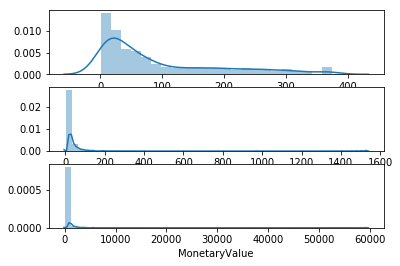

In [28]:
#The plt.subplot(...) call before the seaborn function call allows you to plot several subplots in one chart, you do not have to change it
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Plot distribution of var1
plt.subplot(3, 1, 1); sns.distplot(datamart_rfm['Recency'])

# Plot distribution of var2
plt.subplot(3, 1, 2); sns.distplot(datamart_rfm['Frequency'])

# Plot distribution of var3
plt.subplot(3,1,3);sns.distplot(datamart_rfm['MonetaryValue'])

# Show the plot
plt.show()
#You have now plotted distributions of three variables on a single plot!

You can see none of the variables are normally distributed

C:\Users\samra\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


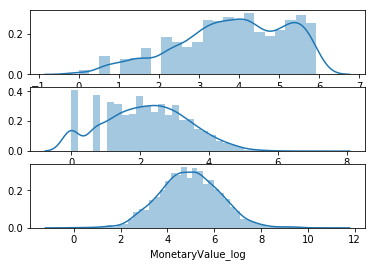

In [29]:
datamart_rfm1= datamart_rfm.copy()
import numpy as np
# Apply log transformation to Recency
datamart_rfm1['Recency_log'] = np.log(datamart_rfm1['Recency'])

# Apply log transformation to Frequency
datamart_rfm1['Frequency_log'] = np.log(datamart_rfm1['Frequency'])
# Apply log transformation to MonetaryValue
datamart_rfm1['MonetaryValue_log'] = np.log(datamart_rfm1['MonetaryValue'])

# Create a subplot of the distribution of Recency
plt.subplot(3, 1, 1); sns.distplot(datamart_rfm1['Recency_log'])

# Create a subplot of the distribution of Frequency
plt.subplot(3, 1, 2); sns.distplot(datamart_rfm1['Frequency_log'])
# Create a subplot of the distribution of MonetaryValue
plt.subplot(3, 1, 3); sns.distplot(datamart_rfm1['MonetaryValue_log'])
# Show the plot
plt.show()

You can see how the skewness was improved with just applying the log transformation!the problem is log works with Positive Data

## Centering variables with different means

K_means works well on variables with the same mean
Centering variables is done by substracting average value from each observation

In [30]:
datamart_centered=datamart_rfm-datamart_rfm.mean()
datamart_centered.describe().round(2)

,Recency,Frequency,MonetaryValue
count,3701.00,3701.00,3701.00
mean,-0.00,0.00,0.00
std,98.78,44.83,1474.29
min,-92.57,-18.15,-379.89
25%,-74.57,-15.15,-321.14
50%,-41.57,-10.15,-240.24
75%,55.43,1.85,-42.74
max,280.43,1512.85,59215.53


K_means works better on variables with the same variance/std
we can scale variables by dividing them by standard deviation of each

In [31]:
datamart_scaled=datamart_rfm/datamart_rfm.std()
datamart_scaled.describe().round(2)
#came up with the same standard deviation

,Recency,Frequency,MonetaryValue
count,3701.00,3701.00,3701.00
mean,0.95,0.43,0.26
std,1.00,1.00,1.00
min,0.01,0.02,0.00
25%,0.19,0.09,0.04
50%,0.53,0.20,0.10
75%,1.51,0.47,0.23
max,3.79,34.17,40.42


Combining centering and scaling
Two options
        1. Combining mean and divide by standard deviation manually
        2. Use a scaler from scikit_learn library (return numpy.ndarray object)
        We use the both option
        

In [32]:
# Normalize the data by applying both centering and scaling
data_normalized_manual = (datamart_rfm- datamart_rfm.mean()) / datamart_rfm.std()
# Print summary statistics to make sure average is zero and standard deviation is one
print(data_normalized_manual.describe().round(2))

       Recency  Frequency  MonetaryValue
count  3701.00    3701.00        3701.00
mean     -0.00      -0.00           0.00
std       1.00       1.00           1.00
min      -0.94      -0.40          -0.26
25%      -0.75      -0.34          -0.22
50%      -0.42      -0.23          -0.16
75%       0.56       0.04          -0.03
max       2.84      33.75          40.17


In [33]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(datamart_rfm)
datamart_normalized=scaler.transform(datamart_rfm)
#datamart_normalized.describe().round(2) if we execute this command we receive an error
#'numpy.ndarray' object has no attribute 'describe'

In [34]:
#we need to ceate a dataframe to show the result 
# Create a pandas DataFrame
data_normalized = pd.DataFrame(datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)
# Print summary statistics
print(data_normalized.describe().round(2))

       Recency  Frequency  MonetaryValue
count  3701.00    3701.00        3701.00
mean     -0.00       0.00           0.00
std       1.00       1.00           1.00
min      -0.94      -0.40          -0.26
25%      -0.75      -0.34          -0.22
50%      -0.42      -0.23          -0.16
75%       0.56       0.04          -0.03
max       2.84      33.75          40.17


In [35]:
print('mean: ', datamart_normalized.mean(axis=0).round(2))
print('std: ', datamart_normalized.std(axis=0).round(2))

mean:  [-0.  0.  0.]
std:  [1. 1. 1.]


 Sequence Of the pre-process
Note: 
1.Log transformation only works with positive data, so should come first. Since the data we use for segmentations is positive , we do not have any problem
2.Normalization forces data to have negative values and log will not work
Let's do the process Again

## Sequence:

    1.Unskew the data - log transformation
    2.Standardize to the same average values
    3.Scale to the same standard deviation
    4.Store as a separate array to be used for clustering

In [36]:
#unskew the data with log transformation
import numpy as np
datamart_log=np.log(datamart_rfm)

In [37]:
#Normalize the variables with StandardScaler
scaler=StandardScaler()
scaler.fit(datamart_log)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [38]:
#Store it separately for clustering
datamart_normalized=scaler.transform(datamart_log)

In [39]:
# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)


C:\Users\samra\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


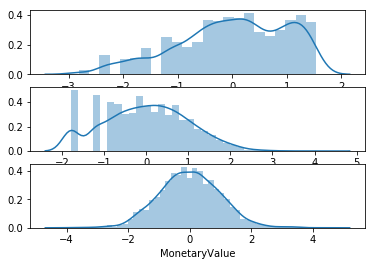

In [40]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_normalized['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_normalized['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_normalized['MonetaryValue'])

# Show the plot
plt.show()

You can see how the skewness is managed after applying these transformations!

Implementation of k-means clustering

## Methods to define the number of clusters
        Visual methods-elbow criterion
        Mathematical methods-silouette coefficient
        Experimentaion and interpretation
        
    

### Visual Method
    Elbow criterion method
      Plot the number of clusters against within-cluster sum-of-squared-errors (SSE) - sum of squared distances from every data point to their cluster center
       Identify an "elbow" in the plot
             elbow is a point representing an "optimal"number of clusters

In [41]:
# Import key libraries
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt
# Fit KMeans and calculate SSE for each *k*
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center


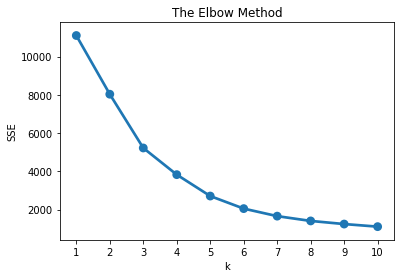

In [42]:
# Plot SSE for each *k*
plt.title('The Elbow Method')
# Add X-axis label "k"
plt.xlabel('k'); 
# Add y-axis label "k"
plt.ylabel('SSE')
# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()
#Best to choose the point on elbow , or the next point
#Use as a guide but test multiple solutions

### Experimentation
Build clustering at and around elbow solution
Analyze their properties - average RFM values
Compare against each other and choose one which makes most business sense

In [43]:
#Import KMeans from sklearn library and initialize it as kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=1)

In [44]:
#Compute k_means clustering on pre-processes data
kmeans.fit(datamart_normalized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [45]:
#Extract cluster lables from labels_attribute
cluster_labels=kmeans.labels_

In [46]:
#check how these clusters are differenet from each other and we do that from raw data
#Analyzing average RFM values of each cluster

#Create a cluster label column in the original DataFrame:
datamart_rfm_k2=datamart_rfm.assign(Cluster=cluster_labels)

In [47]:
#Calculate average RFM  values and size for each cluster:
datamart_rfm_k2.groupby(['Cluster']).agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean','count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         145.0       5.0          91.0  1994
1          34.0      35.0         719.0  1707

as seen her, cluster  zero belonged to people whose transcation is not recent  and less frequent. Their monetary value contribution is loq as well.

In [48]:
#Import KMeans from sklearn library and initialize it as kmeans
from sklearn.cluster import KMeans
kmeans3 = KMeans(n_clusters=3, random_state=1)
#Compute k_means clustering on pre-processes data
kmeans3.fit(datamart_normalized)
#Extract cluster lables from labels_attribute
cluster_labels_3=kmeans3.labels_
#check how these clusters are differenet from each other and we do that from raw data
#Analyzing average RFM values of each cluster

#Create a cluster label column in the original DataFrame:
datamart_rfm_k3=datamart_rfm.assign(Cluster=cluster_labels_3)
#Calculate average RFM  values and size for each cluster:
datamart_rfm_k3.groupby(['Cluster']).agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean','count'],
}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          15.0      52.0        1103.0   890
1         171.0       3.0          55.0  1213
2          78.0      13.0         225.0  1598

# Profile and interpret segments

### Approaches to build customer personas
      1. Summary statistics for each cluster e.g.average RFM values
      2. Snake plots(from market research)
      3. Relative importance of cluster attributes compared to population
      

### Summary statistics for each cluster e.g.average RFM values
     compare the result of 2 and 3 clusters above 
 

### Snake plots to understand and compare segments
        Market research technique to compare different segments
        1.Visual representation of each segment's attributes
        2.Need to first normalize data (center & scale)
        3. Plot each cluster's average normalized values of each attribute

In [49]:
#Prepare data for a snake plot
#Transform datamart_normalized as DataFrame and add a Cluster column
datamart_normalized = pd.DataFrame(datamart_normalized, 
                                   index=datamart_rfm.index, 
                                   columns=datamart_rfm.columns)
datamart_normalized['Cluster'] = datamart_rfm_k3['Cluster']

In [60]:
#Melt the data into a long format so RFM values and metric names are stored in 1 column each
datamart_melt = pd.melt(datamart_normalized.reset_index(), 
                    id_vars=['CustomerID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                    var_name='Attribute', 
                    value_name='Value')
datamart_melt

,CustomerID,Cluster,Attribute,Value
0,12747,0,Recency,-2.006834
1,12748,0,Recency,-2.813936
2,12749,0,Recency,-1.795486
3,12820,0,Recency,-1.795486
4,12822,2,Recency,0.307248
5,12823,1,Recency,1.361543
6,12824,2,Recency,0.181653
7,12826,0,Recency,-2.006834
8,12827,1,Recency,-0.245204
9,12828,0,Recency,-1.286261


C:\Users\samra\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


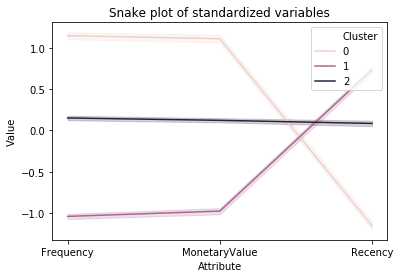

In [51]:
#Visulaize a snake plot
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=datamart_melt)

C:\Users\samra\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


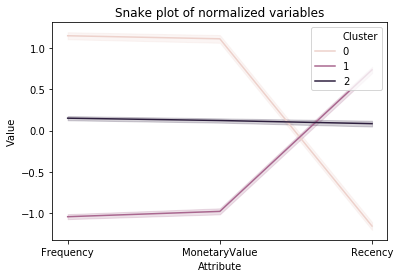

In [62]:
#Another way of drawing
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Attribute')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=datamart_melt, x='Attribute', y='Value', hue='Cluster')
plt.show()

### Relative importance of cluster attributes compared to population
        It is a useful technique to identify relative importance of each segment's attribute
        calculate average values of each cluster

In [52]:
#calculate avergae values of each cluster
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean()

In [54]:
#calculate average values of population
population_avg=datamart_rfm.mean()

In [55]:
#calculate importanc escore by dividing them and substracting 1(ensures 0 is returned when cluster average equals population average)
relative_imp=cluster_avg/population_avg-1


In [57]:
relative_imp.round(2)


,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.84,1.71,1.90
1,0.83,-0.84,-0.86
2,-0.17,-0.32,-0.41


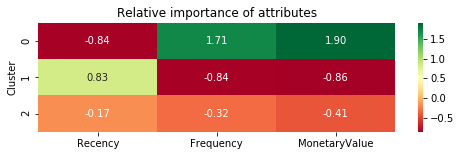

In [59]:
#Plot a heatmap for easier interpretation:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()
#The further a ratio is from 0, the more important that attribute is for a segment relative to the total population

### Key steps of the segmentation project
    Gather data - updated data with an additional variable
    Pre-process the data
    Explore the data and decide on the number of clusters
    Run k-means clustering
    Analyze and visualize results